# Spint 5 - Integrated Project I
---
## Introduction

In this project we will be working for an online video game vendor named Ice. We will analyze historical video game data going back from 2016. We will identify patterns in the data that determine if a game succeeds snd use this information to identify successful titles, as well as plan an advertising campaign.

The dataset we'll be analyzing in this notebook can be found here or if link is broken can be found within this repo named `games.csv`:

<a href='https://practicum-content.s3.us-west-1.amazonaws.com/datasets/games.csv'>games.csv</a>

We will test the following <strong>hypotheses</strong>:
- Average user ratings of the Xbox One and PC platforms are the same. 
- Average user ratings for the Action and Sports genres are different.

This project will consist of:
1. Data Overview
2. Data Analysis
3. Hypotheses Testing
4. Conclusion

<em>ENJOY!</em>

## Data Overview
---

#### <b>Data Description:</b>
- Name
- Platform
- year_of_release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD millions)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB)

<em>This data is from 2016 and may be incomplete</em>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Loading dataset
df = pd.read_csv('~/Triple_Ten_Projects/Sprint_5/games.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
# Viewing dataset sample
df.sample(3, random_state=42)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
3485,London 2012: The Official Video Game of the Ol...,X360,2012.0,Sports,0.07,0.44,0.00,0.07,NaN,NaN,NaN
5500,Etrian Odyssey,DS,2007.0,Role-Playing,0.19,0.02,0.09,0.02,75.0,8.5,T
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Quick look at the data shows the colunn names should be changes to lowercase to fit standard practice.

`"year_of_release"` should be "int64" dtype. 

`"Platform'`, `"Genre"`, and `Rating` will be converted to "category" type

# Data Preprocessing
---

In [4]:
# Adjusting column case
df.columns = df.columns.str.lower()

# Confirming changes made
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [5]:
df.duplicated().sum()

0

No explicit duplicates found thus far. Let's try a different approach in finding some implicit duplicates.

In [6]:
# CHecking for duplicates rows with same title naem and platform
df[["name","platform"]].duplicated().sum()

5

4 implicit duplicates found. We'll drop them to mitigate any possible bias.

In [7]:
# Dropping duplicates found
df = df.drop(df[df[["name","platform"]].duplicated()].index)

# Confirming changes
df[["name","platform"]].duplicated().sum()

0

In [8]:
# Checking for missing values in the dataset
df.isna().sum()/df.shape[0]

name               0.000060
platform           0.000000
year_of_release    0.016038
genre              0.000060
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513285
user_score         0.400958
rating             0.404847
dtype: float64

We'll go through each column one by one to address the missing columns as best we can while keeping the data as honest as possible.

`critic_score`, `user_score`, and `rating` missing values are above 50%, 40%, and 40% respectively. We'll have to be creative in filling those missing values in without imposing any artificial bias.

In [9]:
# Removing the rows with missing `name` value as that data is not useful and resetting index
df = df.dropna(subset=["name"]).reset_index(drop=True)

# Confirming removal
df["name"].isna().sum()

0

In [10]:
# Checking for any unconventional placeholders for missing values
df.query("name in ' '")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


In [11]:
# Checking for duplicate `names` before and after changing case
print(df["name"].str.lower().nunique())

print(df["name"].nunique())

11559
11559


`"name"` column does not seem to have any unconventional placeholders for additional missing values and checking for any duplicate names under different casing

In [12]:
# Checking for any unconventional placeholders for missing values
df['year_of_release'].value_counts(dropna=False)

year_of_release
2008.0    1427
2009.0    1426
2010.0    1255
2007.0    1197
2011.0    1136
2006.0    1006
2005.0     938
2002.0     829
2003.0     775
2004.0     762
2012.0     651
2015.0     606
2014.0     581
2013.0     544
2016.0     502
2001.0     482
1998.0     379
2000.0     350
1999.0     338
1997.0     289
NaN        268
1996.0     263
1995.0     219
1994.0     121
1993.0      60
1981.0      46
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1989.0      17
1983.0      17
1990.0      16
1987.0      16
1988.0      15
1985.0      14
1984.0      14
1980.0       9
Name: count, dtype: int64

In order to change these values to integer dtype we'll have to address the missing values

Let's filter for the missing values to see which instances are missing those values

In [13]:
# Filtering to view rows with missing `year_of_release` values
df[df['year_of_release'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


I notice a couple titles that are on multiple platoforms, like "Madden NFL 2004". Let's check how many titles with missing `year_of_release` have duplicate `name` values. We'd be able to fill said missing values with the values of the duplicate titles on different `platform`

In [14]:
# Checking count of missing values in rows with duplicate `name` vales
df[df["name"].duplicated()]["year_of_release"].isna().sum()

104

There appears to be 104 rows with duplicate `name` values that are missing `year_of_release` values. we'll use the groupby method to group titles by name and `year_of_release` to fill in the missig values with that of those duplicate `name` values using a lambda function

In [15]:
# Grouping data by name and release year to fill missing `year_of_release` values using lambda function
df["year_of_release"] = df.groupby(
    "name"
    )["year_of_release"].transform(
    lambda x: x.fillna(x.dropna().iloc[0] if len(x.dropna()) > 0 else x))

In [16]:
# Viewing missing value count change
df[df["name"].duplicated()]["year_of_release"].isna().sum()

13

13 rows with duplicate `name` values with missing `yea_of_release` values remain. We'll label those and the other missing values as `"unknown"`

In [17]:
# Filling NaN values with "unknown"
df["year_of_release"] = df["year_of_release"].fillna("unknown")

# Confirming changes
df["year_of_release"].isna().sum()

0

In [18]:
# Checking genre values
df["genre"].value_counts(dropna=False)

genre
Action          3369
Sports          2347
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1247
Platform         887
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: count, dtype: int64

No missing values but number of `genre` values should be condensed to 10 unique values and converted to categorical type

In [19]:
# Consolidating 'Strategy' and 'Puzzle' values to 'Misc' 
df["genre"] = df["genre"].replace({
    "Puzzle" : "Misc",
    "Strategy" : "Misc"
})

# Converting type to category
df["genre"] = df["genre"].astype("category")

In [20]:
# Confirming changes
print("Genre dtype: ",df["genre"].dtype)
df["genre"].value_counts()


Genre dtype:  category


genre
Action          3369
Misc            3013
Sports          2347
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1247
Platform         887
Simulation       873
Fighting         849
Name: count, dtype: int64

In [21]:
# Checking critic score missing values 
df["critic_score"].value_counts(dropna=False)

critic_score
NaN     8576
70.0     256
71.0     254
75.0     245
78.0     240
        ... 
20.0       3
21.0       1
17.0       1
22.0       1
13.0       1
Name: count, Length: 83, dtype: int64

We'll leave these as is and will revisit once data has been cleaned to better analyze the data and see if we can figure out why these score are missing and how to best handle them.

In [22]:
# Checking the user score missing values 
df["user_score"].value_counts(dropna=False)

user_score
NaN    6699
tbd    2424
7.8     324
8       290
8.2     282
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: count, Length: 97, dtype: int64

Here we'll have to change the dtype to numeric and coerce the errors to convert the 'tbd' values to NaN. This will aloow us to manipulate the values once we decide on how to handle this missing data.

In [23]:
# Converting 'tbd' to NaN values
df["user_score"] = df["user_score"].replace({
    "tbd" : np.nan
})

# Confirming changes
df["user_score"].value_counts(dropna=False)

user_score
NaN    9123
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.5       2
0.3       2
1.1       2
0         1
9.7       1
Name: count, Length: 96, dtype: int64

In [24]:
# Checking rating missing values
df["rating"].value_counts(dropna=False)

rating
NaN     6764
E       3989
T       2959
M       1563
E10+    1419
EC         8
K-A        3
RP         3
AO         1
Name: count, dtype: int64

In [25]:
# Changing missing values to 'unknown'
df["rating"] = df["rating"].fillna("unknown")
# Confirming changes
df["rating"].value_counts(dropna=False)

rating
unknown    6764
E          3989
T          2959
M          1563
E10+       1419
EC            8
K-A           3
RP            3
AO            1
Name: count, dtype: int64

In [26]:
# Changing `rating` dtype to category
df["rating"] = df["rating"].astype("category")

# Confirming change
df["rating"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 16709 entries, 0 to 16708
Series name: rating
Non-Null Count  Dtype   
--------------  -----   
16709 non-null  category
dtypes: category(1)
memory usage: 16.8 KB


In [27]:
# Rechecking for duplicates
df.duplicated().sum()

0

Now that we've identified missing values and found no duplicates in our sample; we can now make the following changes to finish cleaning this DataFrame for preprocessing:
- `User_Score` value scale (0-10) to match `Critic_Score` (0-100) to better analyze the dataset
- create a `total_sales` column to compare overall performance of individual games, genres, platform, etc.

In [28]:
# Revisiting dtypes 
df.info()
# Viewing the first rows of the dataset
df.sample(3, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16709 entries, 0 to 16708
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   name             16709 non-null  object  
 1   platform         16709 non-null  object  
 2   year_of_release  16709 non-null  object  
 3   genre            16709 non-null  category
 4   na_sales         16709 non-null  float64 
 5   eu_sales         16709 non-null  float64 
 6   jp_sales         16709 non-null  float64 
 7   other_sales      16709 non-null  float64 
 8   critic_score     8133 non-null   float64 
 9   user_score       7586 non-null   object  
 10  rating           16709 non-null  category
dtypes: category(2), float64(5), object(4)
memory usage: 1.2+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3601,Tetris Party Deluxe,Wii,2010.0,Misc,0.33,0.16,0.02,0.05,72.0,5.8,E
11095,Defender,XB,2002.0,Misc,0.07,0.02,0.00,0.00,69.0,NaN,T
16707,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown


In [29]:
# Checking platform values for any possible issues
df["platform"].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [30]:
# Changing `platform` to category dtype 
df["platform"] = df["platform"].astype("category")
df["platform"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 16709 entries, 0 to 16708
Series name: platform
Non-Null Count  Dtype   
--------------  -----   
16709 non-null  category
dtypes: category(1)
memory usage: 17.7 KB


In [31]:
# Converting `user_score` to float type for multiplication
df["user_score"] = pd.to_numeric(df["user_score"])

# Cheving type
df["user_score"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 16709 entries, 0 to 16708
Series name: user_score
Non-Null Count  Dtype  
--------------  -----  
7586 non-null   float64
dtypes: float64(1)
memory usage: 130.7 KB


In [32]:
# Changing user score values to 100 point scale
df["user_score"] = df["user_score"] * 10

# Confirming changes
df.sample(5, random_state= 42)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3601,Tetris Party Deluxe,Wii,2010.0,Misc,0.33,0.16,0.02,0.05,72.0,58.0,E
11095,Defender,XB,2002.0,Misc,0.07,0.02,0.00,0.00,69.0,NaN,T
16707,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown
15134,NANA: Live Staff Daiboshuu! Shoshinsha Kangei,DS,2007.0,Action,0.00,0.00,0.02,0.00,NaN,NaN,unknown
7035,Tom Clancy's Rainbow Six: Siege,PC,2015.0,Shooter,0.13,0.08,0.00,0.02,79.0,69.0,M


In [33]:
# Creating new `total_sales` column 
df['total_sales'] = df[["na_sales","eu_sales","jp_sales","other_sales"]].sum(axis=1)
df["total_sales"].head()

0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
Name: total_sales, dtype: float64

Let's revisit the missing values in `user_score` and `critic_score`. We'll check to see if the scores have any correlation with `total_sales` with scatterplots.

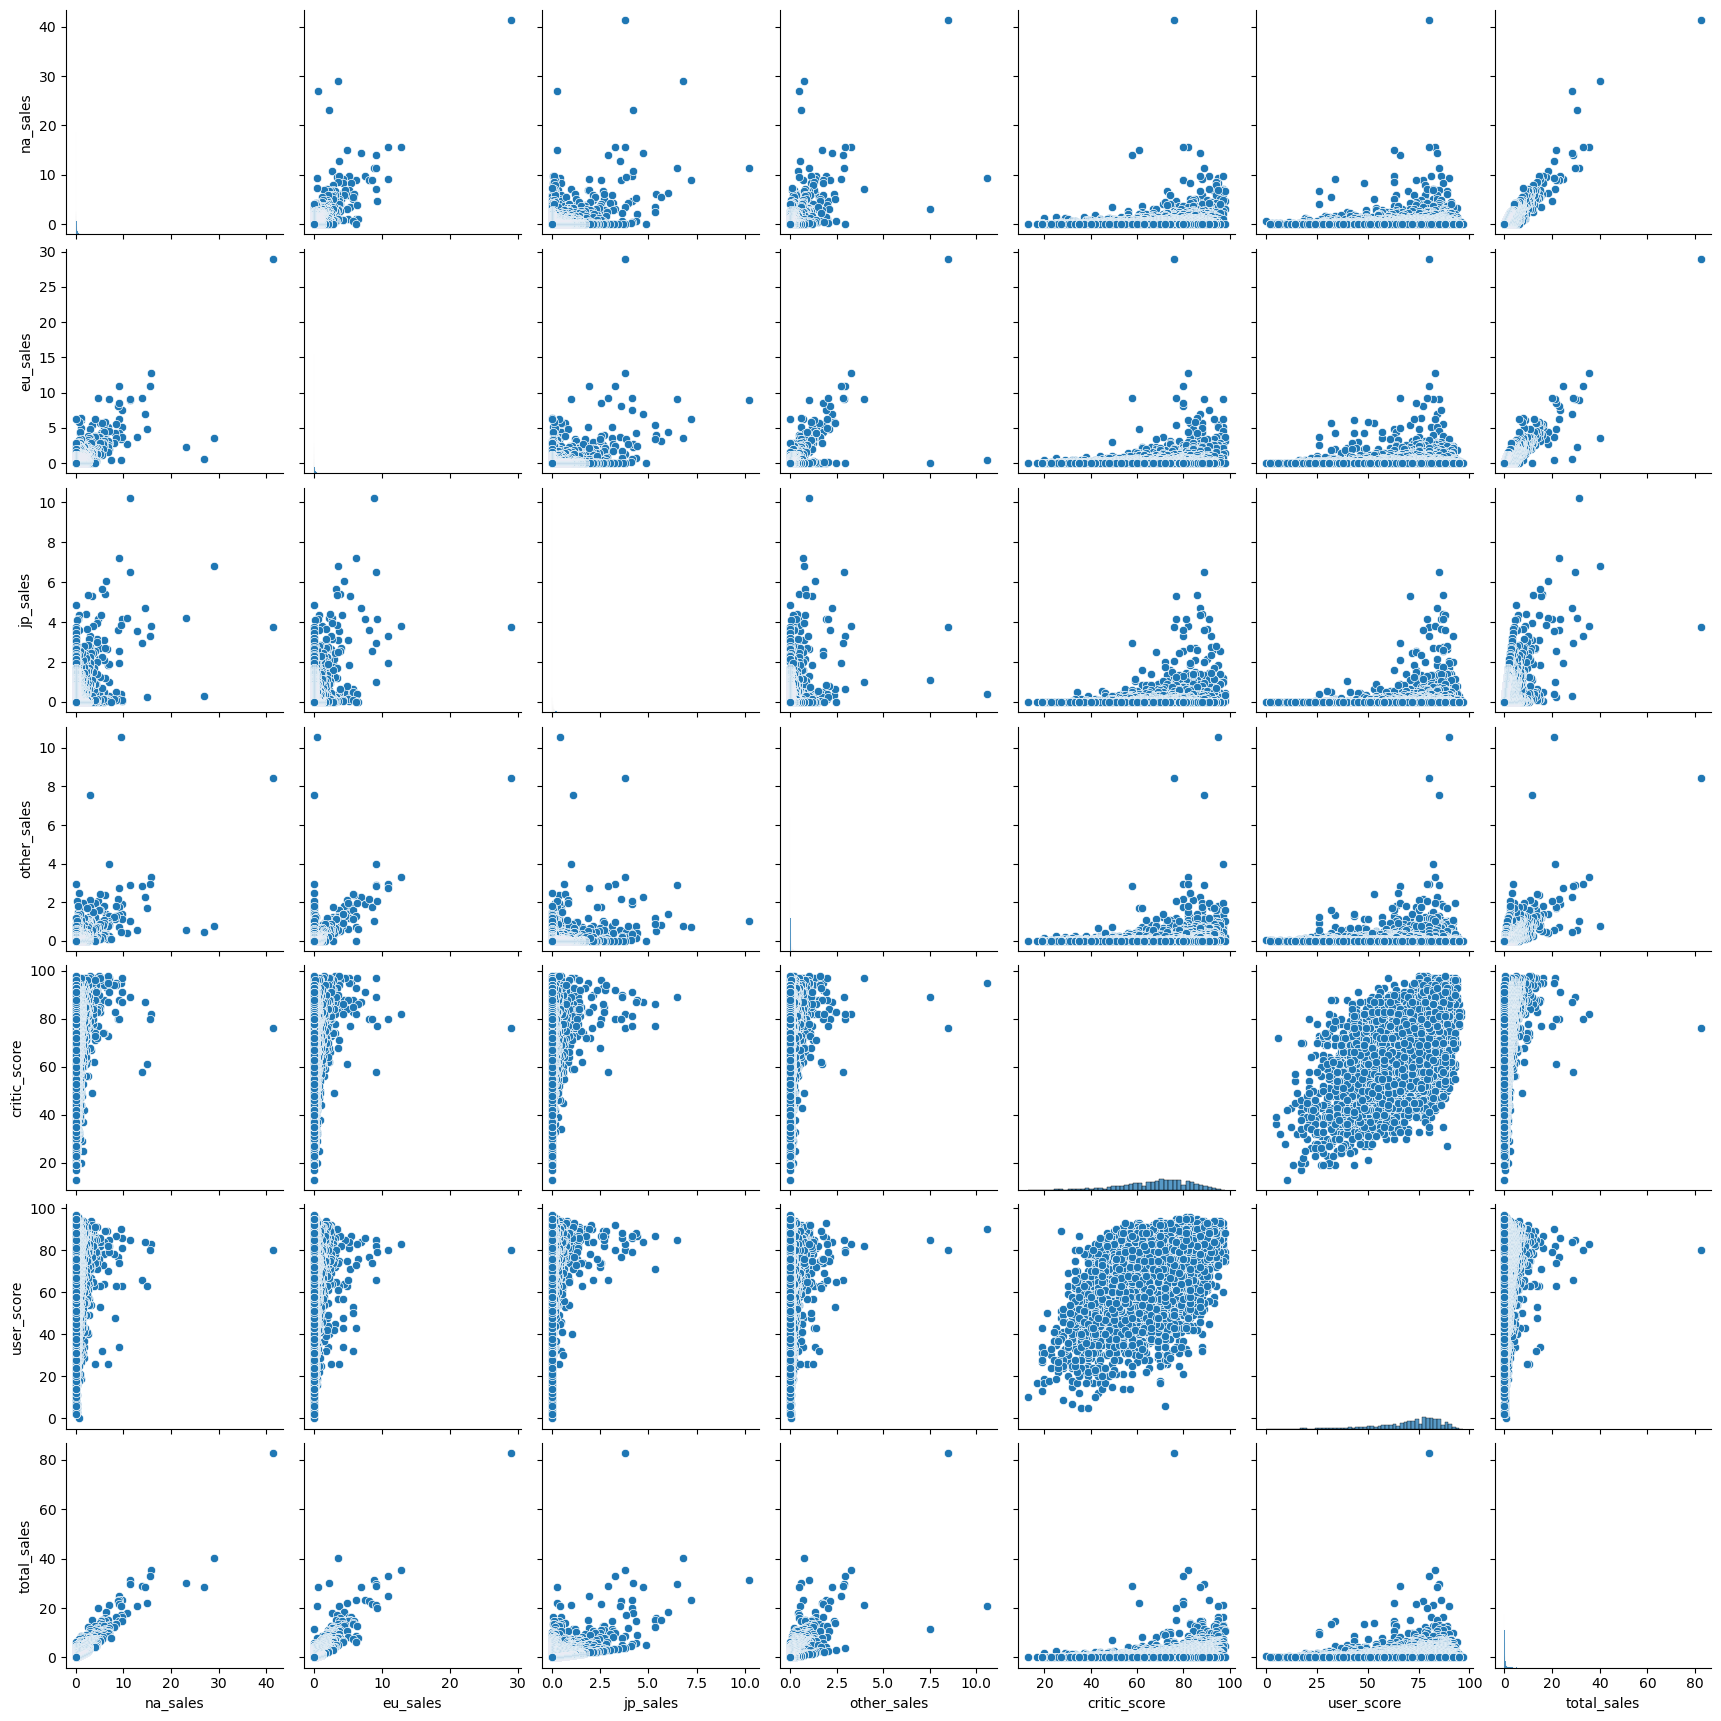

In [34]:
sns.pairplot(df)

We can see a semblence of a positive correlation between `user_score` and `critic_score` with a bit stronger positive correlation bewtween `total_sales` and bnth `user_score` and `critic_score`

We'll categorize the rows by tiered categories ranked by its `total_sales` using the following labels:

- `'Bust'` : < 1.0
- `'Good'` : >= 1.0 and < 5.0
- `'Great'` : >= 5.0 and < 10.0
- `'Classic'` : >= 10.0


We'll then fill in the missing score values with themedian values of the titles within those categories

In [35]:
# Creating function to engineer new temporary column necessary to categorize by total sales
def score_cat(row):
    if row['total_sales'] < 1.0:
        row['score_rank'] = 'Bust'
    elif row['total_sales'] >= 1.0 and row['total_sales'] < 5.0:
        row['score_rank'] = 'Good'
    elif row['total_sales'] >= 5.0 and row['total_sales'] < 10.0:
        row['score_rank'] = 'Great'
    elif row['total_sales'] >= 10.0:
        row['score_rank'] = 'Classic'
    else:
        row['score_rank'] = 'unknown'
    return row['score_rank']
# Creating temp column
df['score_rank'] = df.apply(score_cat, axis=1)
# Checking median user & critic scores for each score rank
print('User Score Median:')
print(df.groupby(['score_rank'])['user_score'].median())
print()
print('Critic Score Median:')
print(df.groupby(['score_rank'])['critic_score'].median())

User Score Median:
score_rank
Bust       74.0
Classic    79.5
Good       79.0
Great      80.0
Name: user_score, dtype: float64

Critic Score Median:
score_rank
Bust       69.0
Classic    88.0
Good       80.0
Great      88.0
Name: critic_score, dtype: float64


Users are a tough crowd. Hard to please users but critics are a bit more generous with the scores

In [36]:
# Grouping temp column to get median user & critic scores for missing values
df['user_score'] = df.groupby(
    'score_rank'
    )['user_score'].transform(
        lambda x: x.fillna(x.median())
        )

df['critic_score'] = df.groupby(
    'score_rank'
    )['critic_score'].transform(
        lambda x: x.fillna(x.median())
        )

# Removing temp column
df = df.drop('score_rank',axis=1)

# Checking changes
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
total_sales        0
dtype: int64

In [37]:
# Decalring cleaned df in new variable signaling cleaned df
df_clean = df

Data cleaning and preprocessing complete. Now we're ready to start our analysis!

## Data Analysis
---

We're going to look into the following:
- yearly performance of each category (e.g. `genre`, `platform`, region)
- spot any past and/or present trends and how long they last
- performance by region
- general distributions of genres 

In [38]:
# Eliminating unknown values to avoid errors when plotting
no_unknown = df_clean[df_clean['year_of_release']!='unknown'] 

# Getting total releases per year grouped with genres
genre_counts = no_unknown.groupby(
    ['year_of_release', 'genre']
    )['name'].count().unstack(fill_value=0)

# Getting total & average sales per year
total_sales_year = no_unknown.groupby(
    'year_of_release'
    ).agg({
        'total_sales' : ['sum','mean']
        }).reset_index()

total_sales_year.columns = ['year','total_sales','average_sales']

# Printing new tables
print(f'Total counts by genre:\n\n{genre_counts.head(5)}\n')
print('Average Sales per Year: \n')
print(total_sales_year[['year','average_sales']].head())

Total counts by genre:

genre            Action  Adventure  Fighting  Misc  Platform  Racing  \
year_of_release                                                        
1980.0                1          0         1     4         0       0   
1981.0               25          0         0     2         3       1   
1982.0               18          0         0     4         5       2   
1983.0                7          1         0     2         5       0   
1984.0                1          0         0     4         1       3   

genre            Role-Playing  Shooter  Simulation  Sports  
year_of_release                                             
1980.0                      0        2           0       1  
1981.0                      0       10           1       4  
1982.0                      0        5           0       2  
1983.0                      0        1           0       1  
1984.0                      0        3           0       2  

Average Sales per Year: 

     year  averag

/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/2365346217.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genre_counts = no_unknown.groupby(


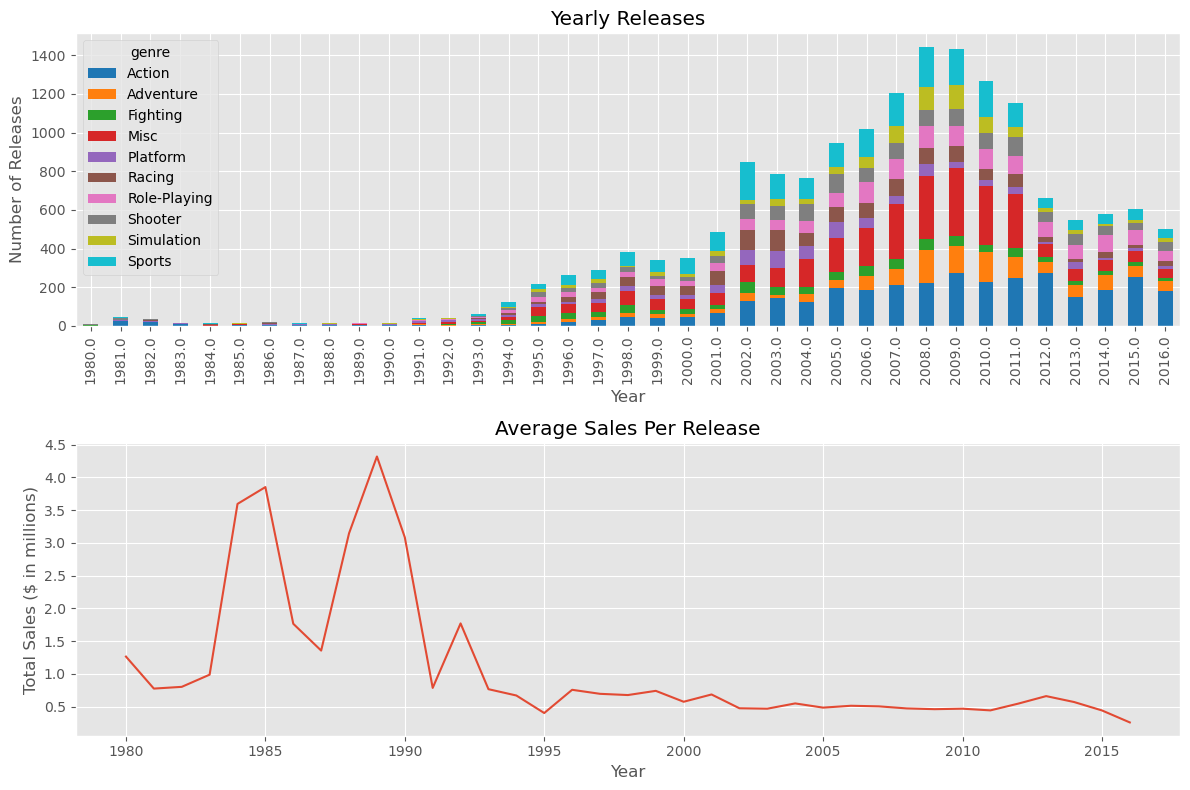

In [39]:
plt.style.use('ggplot')

# Creating subplots for total releases per year and average total sales per release
fig, axes = plt.subplots(2,1,figsize=(12,8))

genre_counts.plot(
    kind = 'bar', 
    stacked = True, 
    colormap = 'tab10',
    ax=axes[0]
    )
axes[0].set_title('Yearly Releases')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Releases')

sns.lineplot(
    data = total_sales_year, 
    x = 'year',
    y = 'average_sales',
    ax = axes[1]
    )
axes[1].set_title('Average Sales Per Release')
axes[1].set_ylabel('Total Sales ($ in millions)')
axes[1].set_xlabel('Year')

plt.tight_layout()
plt.show()

There was a very low amount of development of video games within the first 10-15 years which is typical of a nascent market with only 9 titles in 1980 up to a peak of over 1400 in 2008-2009, as shown in figure one above. Looking at the genres released throughout the years, 'Action' has had the most releases in the better part of the first decade but the number of 'Sports' titles took over during the mid-late 90s through mis 2000's. These numbers indicate popularity of said genres in those timeframes given the pop culture of the times. The popularity of the top athletes of that decade (i.g Michael Jordan, Mike Tyson, Sammy Sosa, etc.) likely fueled the demand for 'Sports' games.

We see the trend of the 'Action' genre increasing from the early 2000s throughout the end of the chart. It overtook the popularity of the 'Sports' genre in 2003 and the its lead has grown since. It's number of releases per year is approaching 50% of the total number of releases in 2016.

What is phenominal is the average total sales per release in the first decade, as shown in the 2nd figure. Although there was very little development compared to the later years, the average sales (1+ million USD) is indicative of the demand/interest of consumers very early. This likely fueled the number of releases per year starting 1994 with 100 percent increase in the number of releases in 1993 through the peak at 2008/09. As development rapidly increased during mid 90s, the average total sales per release stayed relatively flat through 2015 at about 25 percent of its all time high at ~$4.3 M average per title.

Let's take a look at some more overall yearly sales data, including top platforms to spot some trends, like how long it takes for new platforms to go on the market and how long it takes for old ones to fade.

In [40]:
# Finding top ten selling platforms
top_ten_platforms = list(df_clean.groupby(
    'platform'
    )['total_sales'].sum().sort_values(
        ascending=False
        ).index[:10]
        )
top_ten_platforms

/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/2772487165.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_ten_platforms = list(df_clean.groupby(


['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC']

In [41]:
# Creating DataFrame with only top ten selling platforms for analysis
top_platforms = df_clean.query(
    'platform in @top_ten_platforms and year_of_release != "unknown"'
    ).sort_values(
        by = 'year_of_release'
        ) #sorting for better plotting

# Resetting `platform` categories to just keep top ten
top_platforms["platform"] = top_platforms["platform"].astype("object").astype("category")

# Viewing new dataframe
top_platforms.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14465,Alter Ego,PC,1985.0,Simulation,0.00,0.03,0.00,0.01,59.0,58.0,T,0.04
15952,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.00,0.00,0.02,0.00,69.0,74.0,unknown,0.02
14616,SimCity,PC,1988.0,Simulation,0.00,0.02,0.00,0.01,64.0,22.0,E10+,0.03
12646,Syndicate,PC,1992.0,Misc,0.00,0.05,0.00,0.01,69.0,74.0,unknown,0.06
15687,Empire Deluxe,PC,1992.0,Misc,0.02,0.00,0.00,0.00,69.0,74.0,unknown,0.02


An error has been identified. The title 'Strongest Tokyo University Shogi DS' is erroneously listed as released in 1985 but the 'DS' `platform` didn't release until 2004

I'll remove it being that `year_of_release` 'unknown' values return errors when plotting.

In [42]:
# Dropping index with the year of release error
top_platforms=top_platforms.drop(15952)

# Confirming change
top_platforms.head(7)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14465,Alter Ego,PC,1985.0,Simulation,0.00,0.03,0.0,0.01,59.0,58.0,T,0.04
14616,SimCity,PC,1988.0,Simulation,0.00,0.02,0.0,0.01,64.0,22.0,E10+,0.03
12646,Syndicate,PC,1992.0,Misc,0.00,0.05,0.0,0.01,69.0,74.0,unknown,0.06
15687,Empire Deluxe,PC,1992.0,Misc,0.02,0.00,0.0,0.00,69.0,74.0,unknown,0.02
2610,The 7th Guest,PC,1992.0,Adventure,0.02,0.77,0.0,0.00,69.0,74.0,T,0.79
768,SimCity 2000,PC,1992.0,Simulation,1.20,0.84,0.0,0.10,80.0,79.0,unknown,2.14
14605,Doom,PC,1992.0,Shooter,0.02,0.00,0.0,0.00,85.0,82.0,M,0.02


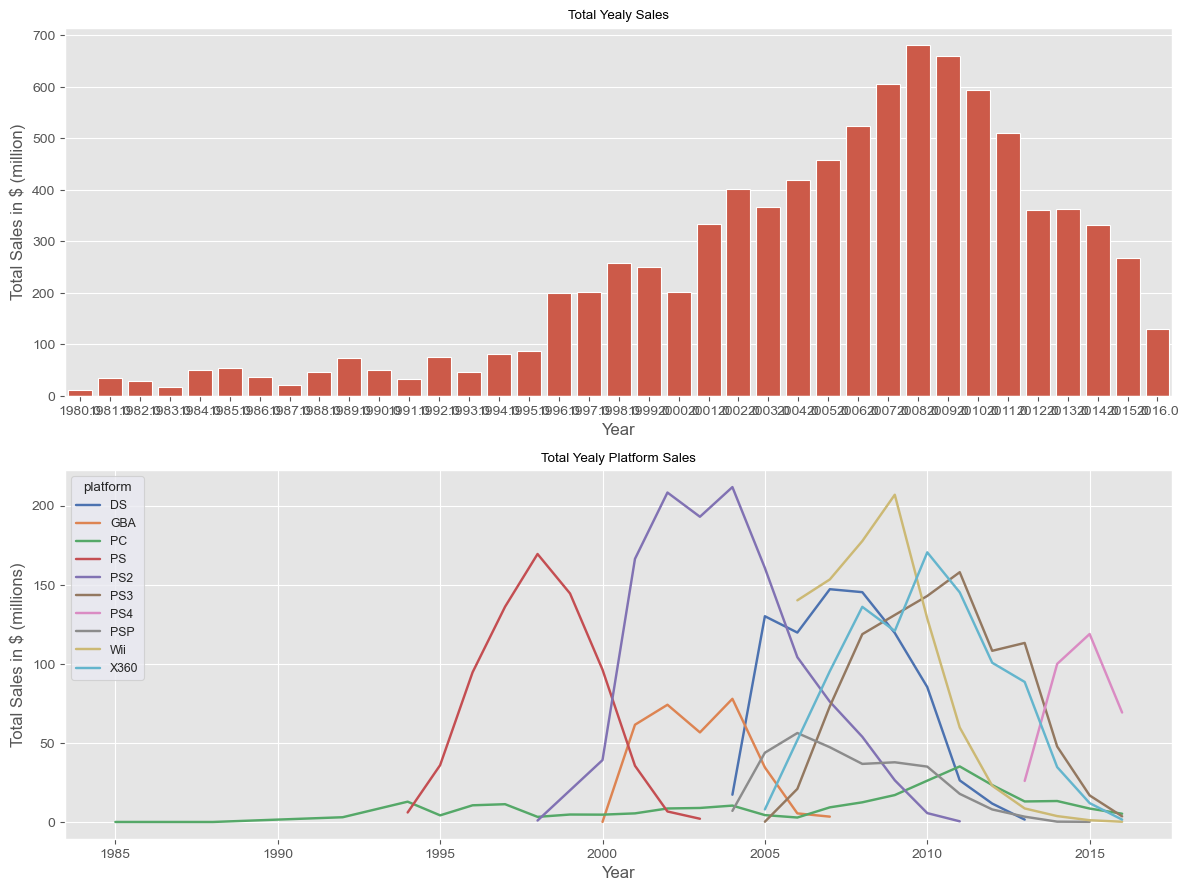

In [43]:
# Charting total sales per year and top platforms' sales plots  
fig, axes =plt.subplots(2,1,figsize=(12,9))
sns.set_theme('paper')
sns.barplot(
    data = total_sales_year,
    x = 'year',
    y = 'total_sales',
    ax = axes[0]
    )
axes[0].set_title('Total Yealy Sales')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Sales in $ (million)')

sns.lineplot(
    data = top_platforms,
    x = 'year_of_release',
    y = 'total_sales',
    hue = 'platform',
    estimator = 'sum',
    err_style = None,
    linewidth = 1.75,
    ax=axes[1]
    )
axes[1].set_title('Total Yealy Platform Sales')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Sales in $ (millions)')

plt.tight_layout()
plt.show()

<a id='platform_sales'></a>
Our total sales per year visual shows that the total sales followed the number of releases per year almost identically. The chart shows there is a downward trend in latest 7 years. Choosing the right platform, genre, and ratings would be the most sensible approach for success.

Judging from the top ten leading platforms in total sales, most of the platforms' sales numbers year over year looks like a normal distribution. Each platforms' sales run from launch to finish lasts about 7-11 years. The only exception is the 'PC' platform. 8 out of the 10 platforms' sales are shrinking to at/near 0. So far it appears that 'PS4' is the leading platform at the end of this dataset and would make the most sense to develop a game for it to have better odds for a successful release.

Now that we have a good overview of the full scope of the data, we'll just keep the last 5 years of data for further analysis.

In [44]:
# Removing data older than 3 years from latest data
recent_df = no_unknown[no_unknown['year_of_release'] >= (2016 - 3)]

# Resetting category values for `platform` eliminating `platforms` with no sales history
recent_df["platform"] = recent_df["platform"].astype("object").astype("category")

/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1127637009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_df["platform"] = recent_df["platform"].astype("object").astype("category")


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/2220854367.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  platform_sales_grp = recent_df.groupby(


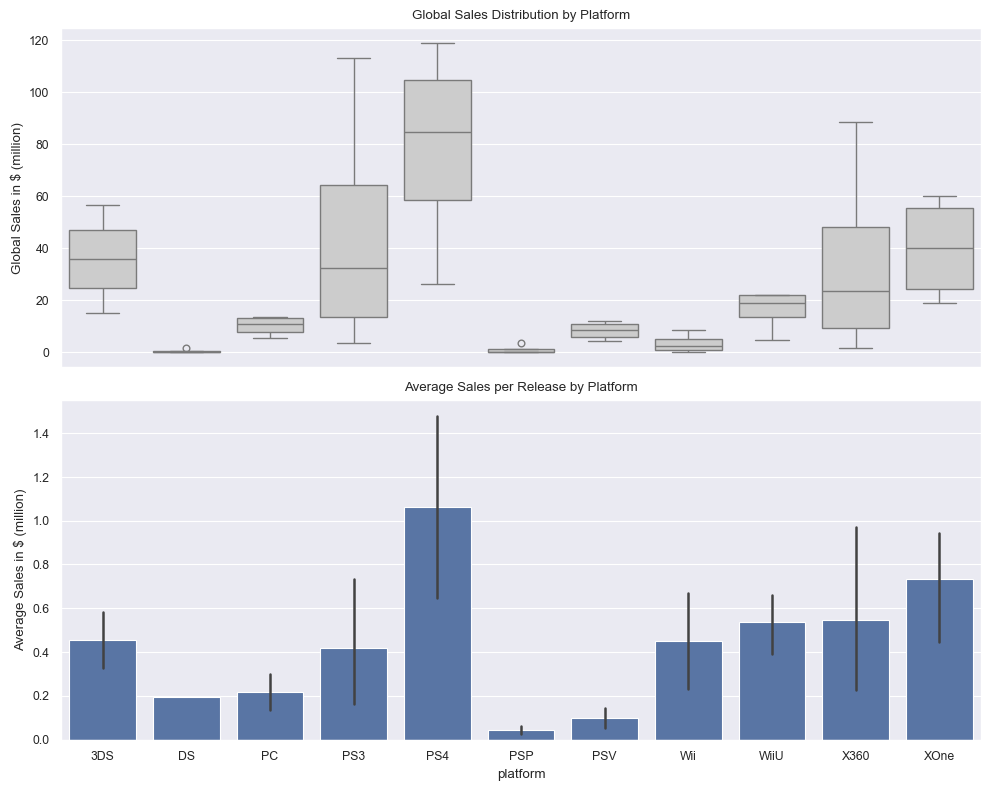

In [45]:
# Grouping the year, platform, and total sales for plotting
platform_sales_grp = recent_df.groupby(
    ['year_of_release','platform']
    ).agg({
        'total_sales':['sum','mean']
        }).reset_index()

platform_sales_grp.columns = ['year','platform','total_sales','average_sales']

# Plot
figs, axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

sns.boxplot(
    data = platform_sales_grp,
    x = 'platform',
    y = 'total_sales',
    color = '0.8',
    ax = axes[0]
    )
axes[0].set_title('Global Sales Distribution by Platform')
axes[0].set_ylabel('Global Sales in $ (million)')
axes[0].set_xlabel('Platform')

sns.barplot(
    data = platform_sales_grp,
    x='platform',
    y='average_sales',
    ax=axes[1]
    )

axes[1].set_title('Average Sales per Release by Platform')
axes[1].set_ylabel('Average Sales in $ (million)')

plt.tight_layout()
plt.show()

<a id='global_platform_comp'></a>
The top figure displays the global sale distribution by platforms for the most recent 3 years. The top 3 are shown to be 'PS3','X360', & 'PS4'. This indicates those 3 platforms have the most volume and highest variability in its sales within the sale 5 years. The 'PS4' has the highest median, with 'PS3' in a very close 2nd, and 'X360' in 3rd place. This figure affirms the assessment that 'PS4' platform is the leader in platform performance at the end of the dataset so far.

The bottom figure visualizes the the average sales per release by platform during the most recent 3 years of the dataset. The top 3 are shown to be 'PS4' at number 1, 'XOne' at 2nd, and 'X360' at a close 3rd. 'PS4' average sales per title is over $200,000 over the next platform, 'XOne'. Both 'PS4' and "XOne are the newer platforms in the dataset which indicates the uptrend for newer consoles and downtrend for the older consoles.

These two figures shows us some very valuable insight but there is more to analyze.

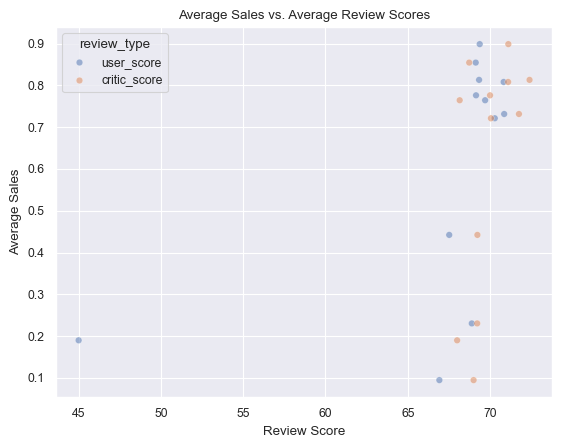

In [46]:
# Selecting PS3 platform to view correlation between user & critic reviews and total sales
ps3_data = no_unknown[no_unknown['platform']=='PS3']

ps3_grp = ps3_data.groupby(['year_of_release']).agg({
    'critic_score':'mean',
    'user_score':'mean',
    'total_sales':'mean'
    }).reset_index()

ps3_melted = ps3_grp.melt(
    id_vars=['total_sales'], 
    value_vars=['user_score', 'critic_score'],
    var_name='review_type', 
    value_name='Score'
    )

# Plot
sns.scatterplot(
    data=ps3_melted, 
    x='Score', 
    y='total_sales', 
    hue='review_type',
    alpha=0.5
    )

# Add title and labels
plt.title("Average Sales vs. Average Review Scores")
plt.xlabel("Review Score")
plt.ylabel("Average Sales")
plt.show()

In [47]:
# Calculating correlation of both critic score and user score vs total sales
corr = ps3_data[['total_sales','critic_score','user_score']].corr()

# Pritning price to scores correlation
print('Critic Scores/Total Sales Correlation: ',corr.loc['total_sales','critic_score'])
print('User Scores/Total Sales Correlation: ',corr.loc['total_sales','user_score'])

Critic Scores/Total Sales Correlation:  0.44027388086929536
User Scores/Total Sales Correlation:  0.05687729565302052


<a id='review_correlation'></a>
We've got a couple scatter plots here to visualize the correlation between user and critic reviews. 

The top figure shows us the average total sales per year for the 'PS3' 'platform' and average user & critic scores. We can see the highest user score average is ~70 and 3 years have been recorded with critic scores averaging higher. There are multiple points showing lower critic scores average a higher total sales than user scores, if not about the same average. 

Below the figure we can see a positive correlation between critic score and total sale as opposed to barely any correlation between user scores and total sales. 

This confirms critic scores hold a stronger, positive correlation on total sales but let's check to see how the same titles fared in other platforms.

In [48]:
# Merging ps3 dataframe with the original dataframe to compare PS3 games pro reviews on other platforms
ps3_comp_scores = df_clean.merge(
    ps3_data, 
    on = ['name','year_of_release'],
    sort = True
    ).query('year_of_release != "unknown"')

# Dropping duplicate columns

ps3_comp_scores = ps3_comp_scores[ps3_comp_scores.columns[~ps3_comp_scores.columns.str.endswith('_y')]]

# Confirming changes
ps3_comp_scores

,name,platform_x,year_of_release,genre_x,na_sales_x,eu_sales_x,jp_sales_x,other_sales_x,critic_score_x,user_score_x,rating_x,total_sales_x
0,Tales of Xillia 2,PS3,2012.0,Role-Playing,0.20,0.12,0.45,0.07,71.0,79.0,T,0.84
1,.hack: Sekai no Mukou ni + Versus,PS3,2012.0,Action,0.00,0.00,0.03,0.00,69.0,74.0,unknown,0.03
2,007: Quantum of Solace,X360,2008.0,Action,0.82,0.51,0.01,0.14,65.0,71.0,T,1.48
3,007: Quantum of Solace,PS3,2008.0,Action,0.43,0.51,0.02,0.19,65.0,66.0,T,1.15
4,007: Quantum of Solace,Wii,2008.0,Action,0.29,0.28,0.01,0.07,54.0,75.0,T,0.65
...,...,...,...,...,...,...,...,...,...,...,...,...
3581,pro evolution soccer 2011,PSP,2010.0,Sports,0.05,0.30,0.29,0.16,74.0,58.0,E,0.80
3582,pro evolution soccer 2011,X360,2010.0,Sports,0.09,0.44,0.00,0.07,79.0,59.0,E,0.60
3583,pro evolution soccer 2011,PS2,2010.0,Sports,0.04,0.21,0.05,0.11,69.0,67.0,E,0.41
3584,pro evolution soccer 2011,Wii,2010.0,Sports,0.07,0.10,0.03,0.02,78.0,54.0,E,0.22


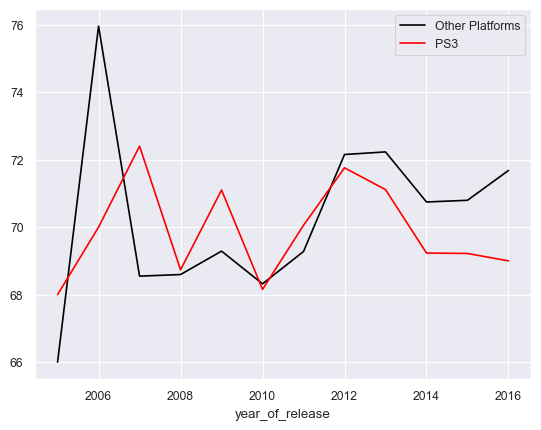

In [49]:
# Checking pro scores difference
other_consoles = ps3_comp_scores.query(
    'platform_x != "PS3"'
    ).groupby(
        ['year_of_release']
        )['critic_score_x'].mean().plot(
            x = 'year_of_release'
            ,color = 'black'
            )

# Plotting critic scores of all PS3 games against the scores of the same games in other platforms
ps3_scritic_scores = ps3_comp_scores.query(
    'platform_x == "PS3"'
    ).groupby(
        ['year_of_release']
        )['critic_score_x'].mean().plot(
            x = 'year_of_release',
            color = 'red'
            )
plt.legend(['Other Platforms','PS3'])
plt.show()

We saw the correlation professional reviews had on the PS3 games. The figure above visualizes the average critic scores of the shared games of PS3 platform against the average critic scores of the same games but on different platforms. This lets us know that the PS3 platform has not fared well vs other platforms since 2014. This indicated a rise of newer platforms as the novelty of the PS3 appeared to have faded. This is not surprising as newer platforms enter the market with enhanced graphics and gameplay, positively affecting review scores. It is safe to say that the 'PS3' platforms has run its course.

In [50]:
# Grouping genres to get distribution and total sales 
recent_genres = recent_df.groupby(['genre']).agg({
    'genre' : 'count',
    'total_sales' : ['sum','mean']
    }).reset_index()

recent_genres.columns = ['genre','count','total_sales','average_sales']
recent_genres

/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/4019871466.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recent_genres = recent_df.groupby(['genre']).agg({


,genre,count,total_sales,average_sales
0,Action,769,322.50,0.419376
1,Adventure,245,23.64,0.096490
2,Fighting,80,35.31,0.441375
3,Misc,229,76.31,0.333231
4,Platform,74,42.63,0.576081
5,Racing,85,39.89,0.469294
6,Role-Playing,292,145.89,0.499623
7,Shooter,187,232.98,1.245882
8,Simulation,62,21.76,0.350968
9,Sports,214,150.65,0.703972


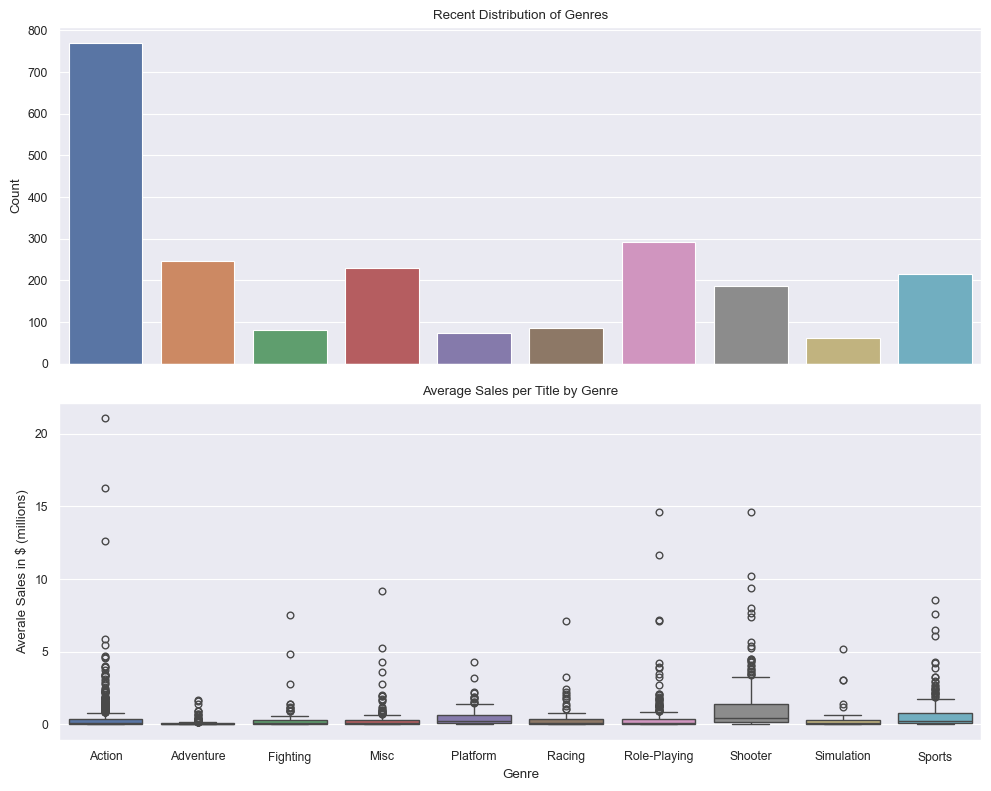

In [51]:
# Plotting recent 5 years genre distribution along with total sales
figs , axes = plt.subplots(2,1,figsize=(10,8),sharex=True)

sns.barplot(
    data = recent_genres,
    x = 'genre',
    y = 'count',
    hue = 'genre',
    ax = axes[0]
    )
axes[0].set_title('Recent Distribution of Genres')
axes[0].set_ylabel('Count')

sns.boxplot(
    data = recent_df,
    x = 'genre',
    y = 'total_sales',
    hue = 'genre',
    ax = axes[1]
    )
axes[1].set_title('Average Sales per Title by Genre')
axes[1].set_ylabel('Averale Sales in $ (millions)')
axes[1].set_xlabel('Genre')

plt.tight_layout()
plt.show()

<a id='recent_genre_distro'></a>
The top figure show us the distribution of the number of releases by `genre` from 2013-2016. The figure shows there's been an overwhelming number of 'Action' titles released, over 2x the amount of the next leading `genre`, 'Role-Playing'. The 'Simulation' `genre` is shown to have the least number of releases in that timespan with around 50 titles.

The second figure visualizes the distibution of `total_sales` for each `genre`. 'Shooter' titles lead the way with a favorable distribution. The median, 3rd, and 4th quartiles are head and shoulders above the rest. 

Given these findings it is safe to say the titles within the `genre` with higher distribution counts have lower average sales which implies higher difficulty to turn maximum profit in developing a game in said genres. The lower the distribution of releases the less competition thus yeilding higher potential return, as highlighted on the lower figure.

We'll now create user profiles for each region to analyze how genres, ratings, and platforms perform in each market.

In [52]:
# Creating a class to make our user profiles
class UserProfile:
    def __init__(self, df, region):
        """
        Initialize the user profile for a specific region.
        
        :param df: DataFrame containing game sales data.
        :param region: The sales column representing the region (e.g., 'na_sales').
        """
        self.df = recent_df
        self.region = region
        self.sales = self.get_sales()
        self.top_genres = self.get_top_genres()
        self.top_platforms = self.get_top_platforms()
        self.top_ratings = self.get_top_ratings()

    def get_sales(self):
        """ Returns the total sales in the region. """
        return self.df[self.region].sum()
    
    def get_top_genres(self, top_n=5):
        """ Returns the top genres based on total sales in the region. """
        return self.df.groupby('genre')[self.region].sum().sort_values(ascending=False).head(top_n)

    def get_top_platforms(self, top_n=5):
        """ Returns the top platforms based on total sales in the region. """
        return self.df.groupby('platform')[self.region].sum().sort_values(ascending=False).head(top_n)
    
    def get_top_ratings(self, top_n=5):
        """ Returns the average sales of each release according to rating in the region"""
        ratings_df = self.df[self.df['rating']!='unknown']
        return ratings_df.groupby('rating')[self.region].sum().sort_values(ascending=False).head(top_n)

    def display_profile(self):
        """ Prints the regional profile in a structured format. """
        print(f"\n📊 User Profile for {self.region.upper()} 📊")
        print("\nTotal Sales:")
        print(f'${self.sales:.2f} million')
        print("\nTop Selling Genres:")
        print(self.top_genres)
        print("\nTop Platforms:")
        print(self.top_platforms)
        print("\nTop Selling Ratings:")
        print(self.top_ratings)

    @staticmethod
    def plot_rating_comparison(profiles):
        """Plots a bar chart comparing the top ratings for all four regions."""
        genre_sales = {}

        # Collect data from each region's profile
        for region, profile in profiles.items():
            genre_sales[region] = profile.get_top_ratings()

        # Convert dictionary to DataFrame
        ratings_df = pd.DataFrame(genre_sales).fillna(0)
        
        # Plot
        plt.figure(figsize=(10, 6))
        ratings_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
        plt.title("Top Ratings by Region")
        plt.xlabel("Rating")
        plt.ylabel("Total Sales (millions)")
        plt.xticks(rotation=45)
        plt.legend(title="Region")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    
    def plot_genre_comparison(profiles):
        """Plots a bar chart comparing the top genres for all four regions."""
        genre_sales = {}

        # Collect data from each region's profile
        for region, profile in profiles.items():
            genre_sales[region] = profile.get_top_genres()

        # Convert dictionary to DataFrame
        genre_df = pd.DataFrame(genre_sales).fillna(0)

        # Plot
        plt.figure(figsize=(10, 6))
        genre_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
        plt.title("Top Genres by Region")
        plt.xlabel("Genre")
        plt.ylabel("Total Sales (millions)")
        plt.xticks(rotation=45)
        plt.legend(title="Region")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def plot_platform_comparison(profiles):
        """Plots a bar chart comparing the top genres for all four regions."""
        platform_region_sales = {}

        # Collect data from each region's profile
        for region, profile in profiles.items():
            platform_region_sales[region] = profile.get_top_platforms()

        # Convert dictionary to DataFrame
        platform_region_df = pd.DataFrame(platform_region_sales).fillna(0)

        # Plot
        plt.figure(figsize=(10, 6))
        platform_region_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
        plt.title("Top Platforms by Region")
        plt.xlabel("Platform")
        plt.ylabel("Total Sales (millions)")
        plt.xticks(rotation=45)
        plt.legend(title="Region")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
# Filter dataset
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']

# Create profiles for each region
profiles = {region: UserProfile(df, region) for region in regions}

# Displaying user profile for North America
print(profiles['na_sales'].display_profile())


📊 User Profile for NA_SALES 📊

Total Sales:
$437.79 million

Top Selling Genres:
genre
Action          126.13
Shooter         109.74
Sports           65.27
Role-Playing     46.40
Misc             31.60
Name: na_sales, dtype: float64

Top Platforms:
platform
PS4     108.74
XOne     93.12
X360     81.66
PS3      63.50
3DS      38.20
Name: na_sales, dtype: float64

Top Selling Ratings:
rating
M       165.29
E        79.05
E10+     54.24
T        49.79
AO        0.00
Name: na_sales, dtype: float64
None


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1148060322.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return self.df.groupby('genre')[self.region].sum().sort_values(ascending=False).head(top_n)
/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1148060322.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return self.df.groupby('platform')[self.region].sum().sort_values(ascending=False).head(top_n)
/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1148060322.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

In [53]:
# Displaying user profile for Europe
print(profiles['eu_sales'].display_profile())


📊 User Profile for EU_SALES 📊

Total Sales:
$392.71 million

Top Selling Genres:
genre
Action          118.61
Shooter          87.86
Sports           60.52
Role-Playing     36.97
Misc             25.26
Name: eu_sales, dtype: float64

Top Platforms:
platform
PS4     141.09
PS3      67.81
XOne     51.59
X360     42.52
3DS      30.96
Name: eu_sales, dtype: float64

Top Selling Ratings:
rating
M       145.80
E        83.36
E10+     42.69
T        41.95
AO        0.00
Name: eu_sales, dtype: float64
None


In [54]:
# Displaying user profile for Japan
print(profiles['jp_sales'].display_profile())


📊 User Profile for JP_SALES 📊

Total Sales:
$141.02 million

Top Selling Genres:
genre
Role-Playing    51.04
Action          40.49
Misc            12.39
Fighting         7.65
Shooter          6.61
Name: jp_sales, dtype: float64

Top Platforms:
platform
3DS     67.81
PS3     23.35
PSV     18.59
PS4     15.96
WiiU    10.88
Name: jp_sales, dtype: float64

Top Selling Ratings:
rating
T       20.59
E       15.14
M       14.11
E10+     5.89
AO       0.00
Name: jp_sales, dtype: float64
None


In [55]:
# Displaying user profile for other regions
print(profiles['other_sales'].display_profile())


📊 User Profile for OTHER_SALES 📊

Total Sales:
$120.04 million

Top Selling Genres:
genre
Action          37.27
Shooter         28.77
Sports          19.45
Role-Playing    11.48
Misc             7.06
Name: other_sales, dtype: float64

Top Platforms:
platform
PS4     48.35
PS3     26.77
XOne    14.27
X360    12.11
3DS      6.28
Name: other_sales, dtype: float64

Top Selling Ratings:
rating
M       47.11
E       22.61
T       14.29
E10+    12.57
AO       0.00
Name: other_sales, dtype: float64
None


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1148060322.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return self.df.groupby('platform')[self.region].sum().sort_values(ascending=False).head(top_n)


<Figure size 1000x600 with 0 Axes>

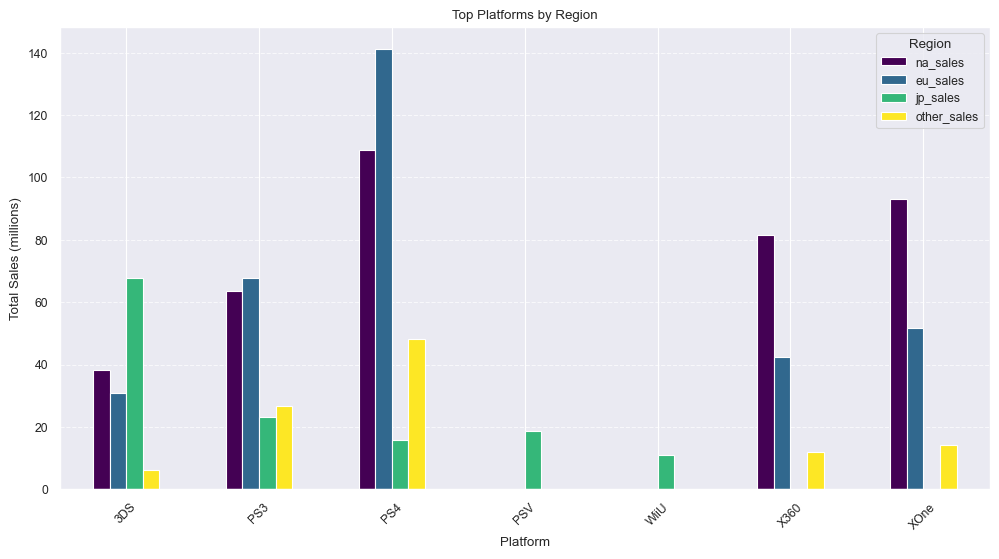

In [56]:
# Plotting top platforms by region
UserProfile.plot_platform_comparison(profiles)

<a id='regional_platforms'></a>
This figure shows us how the top platforms performed in each region. Japan appears to be the only region that loves handhelds. 3 of their top 5 platforms are handheld devices, including the '3DS' which has done well across all regions. WiiU and PSV appear to only have meaningful sales in Japan as well.

North America leads in sales for 'X360' and 'Xone' likely due to being an American product. EU on the other hand leads in 'PS3' and 'PS4' video game sales. North America is in close second in 'PS3' sales and a bit behind in 'PS4' sales but in second place , nonetheless.  
 
This leads us to believe it would make the most sense to target that market for 'PS4' releaes, along with North America.


/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1148060322.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return self.df.groupby('genre')[self.region].sum().sort_values(ascending=False).head(top_n)


<Figure size 1000x600 with 0 Axes>

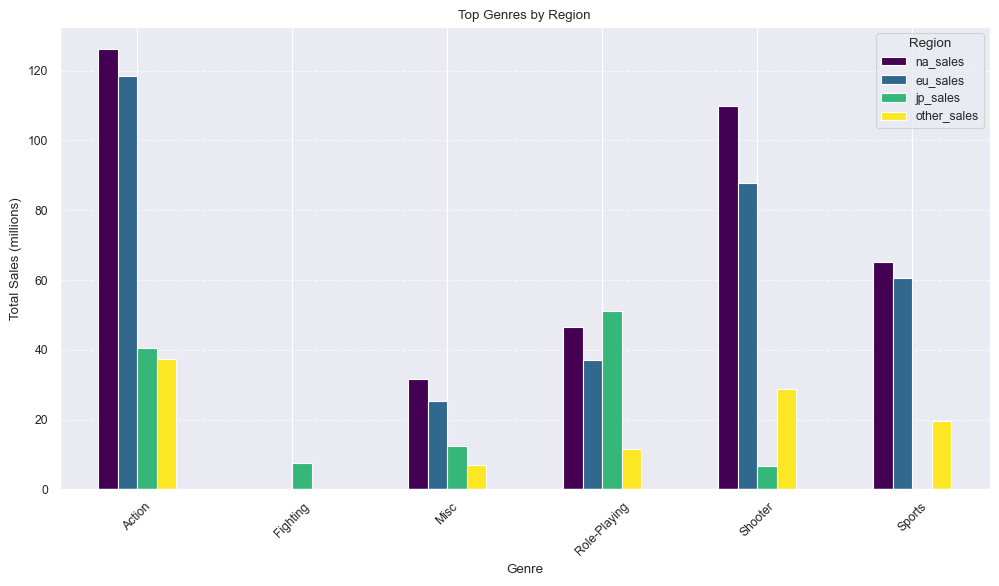

In [57]:
# Plotting top genres by region
UserProfile.plot_genre_comparison(profiles)

Here we notice North America leads all regions in sales of the top 4 out of 6 genres. Japan is the only region that has the 'Fighting' genre ranked in their top 5 genres. North America, Europe, and the Other Regions top genres are almost identical in their ranks. North America's, Europe's, and Other Regions's top selling genres is 'Action' with the three regions' 2nd place genre being 'Shooter', followed by 'Sports'. 

Japan's preferences in video games, 'Role-Playing', and 'Action', is apparent in this figure. This is likely due to fundemental cultural differences (not a bad thing) but should be considered when choosing a region to market games in specific genres.

/var/folders/k2/l0zyqz212sj39xvqd5n787jw0000gp/T/ipykernel_8749/1148060322.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return ratings_df.groupby('rating')[self.region].sum().sort_values(ascending=False).head(top_n)


<Figure size 1000x600 with 0 Axes>

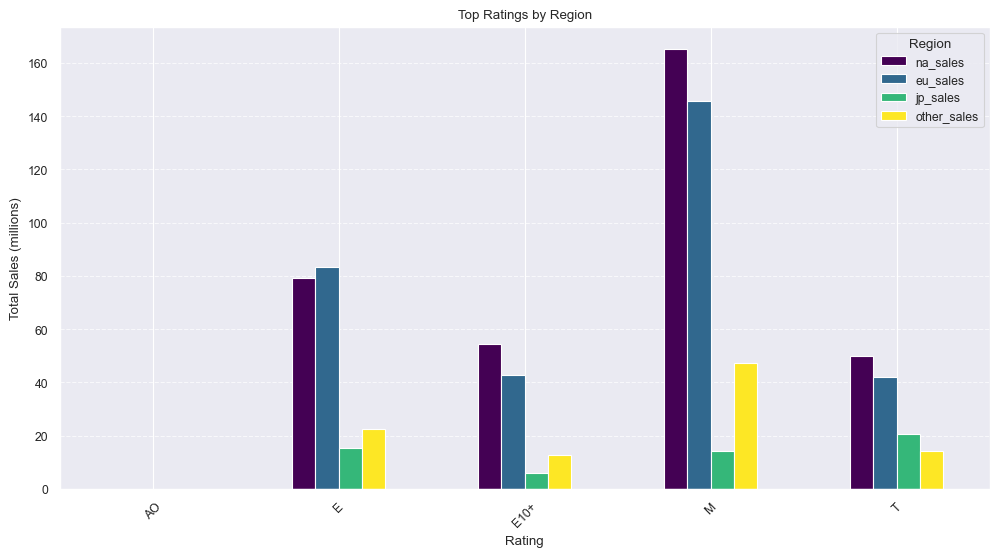

In [58]:
# Plotting top ratings by region
UserProfile.plot_rating_comparison(profiles)

<a id='rating_sales'></a>
When comparing the sales by ESRB `rating` over the most recent 3 years we can determine all regions follow similar trends. Japan appears to have a younger audience being that their top rating in terms of regional sales is 'T'. All other regions suggest having an older audience being that 'M' `rating` is the best seller. There isn't much data to support any interest in 'AO' rated games.

## Hypotheses Testing
---
#### <b>First Hypothesis:</b>

$H_{0}$ = Average user ratings of the Xbox One and PC platforms are the same. <br><br>
$H_{1}$ = Average user ratings of the Xbox One and PC platforms are not the same. 

In [59]:
# Filtering the platforms and isolating the user score and isolating the arrays
xone_user_ratings = df_clean[df_clean['platform'] == 'XOne']['user_score']
pc_user_ratings = df_clean[df_clean['platform'] == 'PC']['user_score']

# Setting alpha value
alpha = 0.05

# Performing t-test
results = st.ttest_ind(xone_user_ratings,pc_user_ratings)

# Printing p-value

print('p-value: ',results.pvalue)

# Intepreting results

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We can\'t reject the null hypothesis')

p-value:  7.317452258948789e-05
We reject the null hypothesis


For our first test; the hypothesis is the average user ratings of the Xbox One and PC platforms are the same. We formulated the null hypothesis by stating the opposite and used the original hypothesis to formulate the alternative hypothesis.

We chose to set an alpha value of 0.05 because we are performing a two-tailed hypothesis comparing the equality of the two samples. The test resulted in the rejection of the null hypothesis. Average user ratings for the XBox One and PC platforms are not the same.

#### <b>Second Hypothesis:</b>

$H_{0}$ There is no difference in the average user ratings for the Action and Sports genres.<br><br>
$H_{1}$ There is a difference in the average user ratings for the Action and Sports genres.

In [60]:
# Filtering user scores for the Action and Sports genres
action_scores = df_clean[df_clean['genre']=='Action']['user_score']
sports_scores = df_clean[df_clean['genre']=='Sports']['user_score']

alpha = 0.05

results = st.ttest_ind(action_scores,sports_scores)

print('p-value: ',results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis')
else:
    print('We can\'t reject the null value')

p-value:  0.7002609613158596
We can't reject the null value


Our second hypothesis tested is 'Average user ratings for the Action and Sports genres are different'. We formulated our null hypothesis by stating the opposite of the hypothesis: 'There is no difference in the average user rating for the Action and Sports genres'. We chose an alpha value of 0.05 because we are comparing the mean values of 2 sample populations and checking if they are equal with some conclusive difference.

As a result from the test, we cannot reject the null hypothesis. It is very likely there is no difference in the average user rating for the Action and Sports genres.

# Conclusion
---

After thorough examination of the dataset, we are confident in our findings. Looking ahead to 2017, we can expect the 'PS4' platform to lead all platforms in sales despite 'X360' performance. I would not choose 'X360' due to it only doing well in North America and Europe. Being that the 'PS4' is fairly new to the market compared to the others with only 3 years in the market, we expect the sales volume to ramp up . All other platforms are on a downtrend in sales which make sthe 'PS4' the platform to develop on especially given it's performance in the regions with the biggest marketshares (North America and Europe).

We expect the 'Action' genre to keep its top rank as the industries' leader in total distribution. The data proves that that the 'Action' genre is diluted, proven with its low sales average per release. We would recommend betting on a 'Shooter' to have the best chances of success. The 'Shooter' genre has ranked well in the 4 regions the most recent 3 years. The average sales per release is head and shoulders above the rest with a low number of releases. Less competition in a high volume market is always a great sign. 

The 'M'(Mature) rating is top selling rating among 75% of the regions by far. This would work out well given 'Shooter' titles are usually rated 'M'. The demand is there and cannot be ignored.

Critic scores proved to have a positive influence on sales. It would make the most sense to cater to the critics in order to recieve favorable ratings to push sales. This can be done by analyzing their past reviews, preferably on 'shooter' title reviews to pander to their preferences for favorable scores. 

It would make most sense to go with a rated 'M' 'Shooter' on the 'PS4' platform to ensure the highest probability of success. Given the age requirements for said rating marketing to adult gamers, or adult video game enjoyers, will elevate success. It would be most effective strategy to target the North American and European markets as the total sales and interest in the values mentioned for a successful game.